# ASI assessed exercise 2018/2019
**Student name: NGUYEN Thanh-Long**

In [0]:
import pandas as pd
import numpy as np
import missingno as msno # Missingno package for visualizing missing data

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

### 1. Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the original training set. (code)  [3] 

In [0]:
# Links of dataset 
urltrain = 'https://bitbucket.org/longng/santander-customer-transaction-prediction/downloads/train.csv'

In [0]:
dftrain = pd.read_csv(urltrain) 

In [0]:
nfeatures = 200 #define number of features for the dataset
df = dftrain.iloc[:,1:nfeatures+2] #drop the index column 
ncols = len(df.columns)
featurecols = dftrain.iloc[:,2:nfeatures+2].columns #name of features 

---

### 2. Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis. (text) [7]

The number of positive class 20098
The number of negative class 179902
The percentage of positive class in total 10.049 

The below table showed up the imbalance between 0 and 1 outcome:


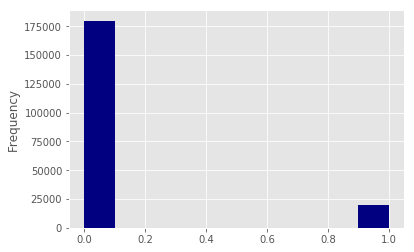

In [0]:
#Check the distribution of output classes 
Totalanomaly = (df['target'].sum())
Totalnormal = (df['target'].count() - Totalanomaly)
percent = ((Totalanomaly)/(df['target'].count())*100)
print('The number of positive class', Totalanomaly)
print('The number of negative class', Totalnormal)
print('The percentage of positive class in total', percent,'\n')

print("The below table showed up the imbalance between 0 and 1 outcome:")
df['target'].plot(fontsize=10,kind='hist', colors='navy')
plt.show()

The class distribution is imbalanced with only 10% in positive class. The number of features are 200, which could consume a huge amount of RAM in calculation.

In [0]:
#Split the data set into train set and test set
nrows = len(df)
x_train, x_test, t_train, t_test = train_test_split(df[:nrows][featurecols], df[:nrows]['target'], test_size=0.5)
print('The distribution of classes in both train and test set:')
display(Counter(t_train), Counter(t_test)) #count the classes in both train and validation set
x_train.shape, x_test.shape, t_train.shape, t_test.shape

The distribution of classes in both train and test set:


Counter({0: 89921, 1: 10079})

Counter({0: 89981, 1: 10019})

((100000, 200), (100000, 200), (100000,), (100000,))

----

### 3. a. Implement Bayesian linear regression (you should already have an implementation from the lab sessions). (code) [10]

$
\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t}
$

In [0]:
def get_w_hat(X_, y, n):
    w_hat = (np.linalg.inv(X_.T.dot(X_))).dot(X_.T).dot(np.array(y))
    return w_hat

Total Loss: $\mathcal{L} = \dfrac{1}{N}\displaystyle\sum_{i=1}^{N} (\mathbf{t}_n - \mathbf{w}^T\mathbf{x}_n)^2 = \dfrac{1}{N} (\mathbf{t} - \mathbf{X}\mathbf{w})^T(\mathbf{t} - \mathbf{X}\mathbf{w})$ 

In [0]:
def lsfit_k(X_, t, k):
    # Compute optimal 'w' and 'loss' for a model of polynomial order 'k'
    w_hat = get_w_hat(X_,t,k)
    loss = np.mean(np.square(t - np.dot(w_hat, X_.T)))
    
    return w_hat, loss

$\hat{\sigma^2} = \dfrac{1}{N}(\mathbf{t}-\mathbf{X}\hat{\mathbf{w}})^T(\mathbf{t}-\mathbf{X}\hat{\mathbf{w}})$

In [0]:
def get_sigma2_hat(X, w_hat, t):
    sigma2_hat = (np.array(t) - X.dot(w_hat)).T.dot(np.array(t) - X.dot(w_hat)) / len(X)
    
    return sigma2_hat

Covariance: $\Sigma = \Big( \dfrac{1}{\sigma^2}\mathbf{X^TX} + \mathbf{S}^{-1} \Big)^{-1}$

In [0]:
def get_cov_posterior(x, t, order, S):
    X_ = get_X(x, order)
    w_hat = get_w_hat(X_, t, order)
    sigma2_hat = get_sigma2_hat(X_, w_hat, t)
    
    cov_posterior = np.linalg.inv((1/sigma2_hat)*X_.T.dot(X_) + np.linalg.inv(S))
    
    return cov_posterior

Mean: $\mu = \dfrac{1}{\sigma^2}\Sigma\mathbf{X^Tt}$

In [0]:
def get_mean_posterior(x, t, order, cov_posterior): 
    X_ = get_X(x, order)
    w_hat = get_w_hat(X_, t, order)
    sigma2_hat = get_sigma2_hat(X_, w_hat, t)
    
    mean_posterior = (1/sigma2_hat)*cov_posterior.dot(X_.T).dot(np.array(t))
    
    return mean_posterior 

### 3. b. Discuss how can you select the (hyper-)parameters for the Gaussian prior (text) [5]

The hyper parameters for Gaussian Prior will be selected as $\mathcal{N}(0, \sigma^2\mathbf{I}) \sim \mathcal{N}(0, \mathbf{I})$ with $\sigma =1$

### 3. c. Write code that calculates the N-th order polynomial transformation of the input data. For simplicity, do not consider polynomials of more than one variable 2 (such as x y), but raise each input variable to the power of N individually. Consider N=1, 2, 3, and 6. (code) [5]

$
\mathbf{X} = \left[ {\begin{array}{ccccc}
   1 & x_1^1 & \dots & x_1^K\\
   1 & x_2^1 & \dots & x_2^K\\
   \vdots &    \vdots & &   \vdots \\
   1 & x_N^1 & \dots & x_N^K\\
  \end{array} } \right]
$

In [0]:
def get_X(x, n):
    """
    Compute the matrix 'X' featuring 'x' raised to higher powers.
    Rescaling of the original inputs is recommended in order to avoid numerical instability.
    """
    if n >= 4:
        x = x - np.mean(x)
    
    X_ = np.ones((len(x), 1))
    for i in range(1, n+1):
        X_ = np.column_stack((X_, np.power(x, i)))
    
    return X_

In [0]:
for k in [1,2,3,6]:
    """
    k is the N-th order polynomial
    """
    X_ = get_X(x_train,k)

### 3. d. Describe any additional pre-processing that you suggest for this data. (text) [5]

In [0]:
# Calculate the missing attributes 
# The results are the total numbers of attributes having missing values and percentages of non-missing values of these attribute
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing = missing[missing['Total']>0]
print("The below table of the attributes having missing values and percentages of non-missing values of these attributes:")
print()
print(missing)
print()
print("The number of attributes have missing values are", len(missing))

The below table of the attributes having missing values and percentages of non-missing values of these attributes:

Empty DataFrame
Columns: [Total, Percent]
Index: []

The number of attributes have missing values are 0


In [0]:
#Imbalance processing with under-sampling technique 
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

# Using under-sampling to process the imbalance between classes.
x_train, t_train = rus.fit_resample(x_train, t_train) 

#count the classes in both train and validation set
display(Counter(t_train), Counter(t_test)) 

x_train.shape, x_test.shape, t_train.shape, t_test.shape

Counter({0: 10079, 1: 10079})

Counter({0: 89981, 1: 10019})

((20158, 200), (100000, 200), (20158,), (100000,))

We suggested to have missing values pre-processing stage. 

Next, due to the imbalanced between classes, we also suggest to have the treatment such as under-sampling technique, in order to achieve better accuracy rate

### 3. e. Treat class labels as continuous and apply regression to the training data. Also, calculate the posterior variance of the weights (code) [10]

In [0]:
#compute covariance
K = 1

#create the identity matrix 
S = np.identity(nfeatures+1) 

#Calculate the posterior variance
cov_posterior_linear = get_cov_posterior(x_train, t_train, K, S)

display(cov_posterior_linear.shape)
cov_posterior_linear

(201, 201)

array([[ 7.74055298e-01,  1.82606361e-06, -3.04365113e-06, ...,
        -1.18101495e-05, -5.50447828e-06, -6.15264969e-07],
       [ 1.82606361e-06,  7.90054929e-07, -4.02798121e-10, ...,
         2.05818165e-08,  9.56027246e-09, -1.01585095e-09],
       [-3.04365113e-06, -4.02798121e-10,  4.56729774e-07, ...,
         4.27473517e-08,  6.86644136e-09,  2.37565843e-11],
       ...,
       [-1.18101495e-05,  2.05818165e-08,  4.27473517e-08, ...,
         8.91556580e-06, -2.48512009e-08, -2.32100592e-09],
       [-5.50447828e-06,  9.56027246e-09,  6.86644136e-09, ...,
        -2.48512009e-08,  8.00525124e-07, -5.06410077e-10],
       [-6.15264969e-07, -1.01585095e-09,  2.37565843e-11, ...,
        -2.32100592e-09, -5.06410077e-10,  7.17987158e-08]])

### 3. f) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy (text) [5]

In [0]:
# source: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Bayesian Linear Regression Prediction: prediction = $\mathbf{X^T_{new}}\mu$

Confusion matrix, without normalization
[[70447 19534]
 [ 2355  7664]]


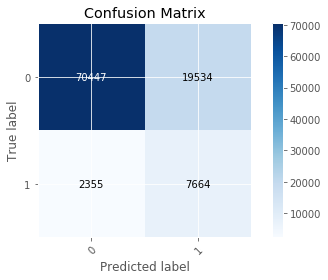

In [0]:
# make prediction on on valuation set with a threshold 0.5 and plot confusion matrix
K=1
X_test = get_X(x_test, K)  #X_test
mean_posterior_linear = get_mean_posterior(x_train, t_train, K, cov_posterior_linear) #calculate the mean ~ w_new

t_pred = np.dot(mean_posterior_linear, X_test.T) #making prediction 

#apply result on threshold to classify target
threshold = 0.5
t_pred[t_pred < threshold] = 0
t_pred[t_pred >= threshold] = 1

# Plot confusion matrix
plot_confusion_matrix(t_test, t_pred, classes=[0,1], normalize=False, title='Confusion Matrix')
plt.show()

In [0]:
accuracy_score(t_test, t_pred)*100

78.11099999999999

In [0]:
target_names = ['class 0', 'class 1']
print(classification_report(t_test, t_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.78      0.87     89981
     class 1       0.28      0.76      0.41     10019

    accuracy                           0.78    100000
   macro avg       0.62      0.77      0.64    100000
weighted avg       0.90      0.78      0.82    100000



### 3. g) Discuss the performance, compare it against a classifier that outputs random class labels. (text) [5]

In [0]:
# build a random classifier: sum all the features, then classify by it result when it <= 0 will be classify as 0, otherwise 1.
random_classifier = x_test.sum(axis=1)
random_classifier[random_classifier <= 0] = 0
random_classifier[random_classifier > 0] = 1

In [0]:
accuracy_score(t_test, random_classifier.as_matrix())*100

10.019

In [0]:
target_names = ['class 0', 'class 1']
print(classification_report(t_test, random_classifier, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00     89981
     class 1       0.10      1.00      0.18     10019

    accuracy                           0.10    100000
   macro avg       0.05      0.50      0.09    100000
weighted avg       0.01      0.10      0.02    100000



Compared with a random classifier, the Linear Regression Classifier still deliver a better classification accuracy, macro F1 score higher as 0.09 vs. 0.64


---

# Logistic Regression Classifier

### 4. a) The goal is to implement a logistic regression classifier that optimizes for the Maximum a Posteriori (MAP) estimate; assume a Gaussian prior on the parameters. As a first step, write a function that calculates the gradient of the joint likelihood. (code) [10]

$$ p(\mathbf{w}|\mathbf{X,t},\sigma^2) = \dfrac{p(\mathbf{t}|\mathbf{X,w},\sigma^2) p(\mathbf{w}|\sigma^2)}{p(\mathbf{t}|\mathbf{X},\sigma^2)} $$

We have joint-likelihood: $p(\mathbf{t}|\mathbf{X,w}) = \displaystyle\prod_{i=1}^{N} p(\mathbf{t_i}|\mathbf{X_i, w})$  but it is difficult to solve the $\dfrac{\partial p(\mathbf{t}|\mathbf{X,w})}{\partial \mathbf{w}} = 0$. 

So we will calculate the  $\dfrac{\partial log\mathsf{g}(\mathbf{w;X,t})}{\partial \mathbf{w}} = 0$

According to the book [A First Course in Machine Learning](http://amzn.com/1498738486), section 4.3 - page 141 we have:

$
\begin{align}
\dfrac{\partial log\mathsf{g}(\mathbf{w;X,t})}{\partial \mathbf{w}}
    &= -\dfrac{1}{\sigma^2}\mathbf{w} + \displaystyle\sum_{i=1}^{N} x_n(t_n - P_n) \\
    &= -\dfrac{1}{\sigma^2}\mathbf{w} + \displaystyle\sum_{i=1}^{N} {x_n\Big(t_n - \dfrac{1}{1 + exp(-\mathbf{w}^T\mathbf{x}_n)}\Big)} \\
    & \text{where } P_n = P(T_n = 1|\mathbf{w,x_n}) = \dfrac{1}{1 + exp(-\mathbf{w}^T\mathbf{x}_n)}\\
\end{align}
$

In [0]:
#implementation MAP
def MAP(X_, t, w, sigma2):
    Pn = 1/(1 + np.exp(-np.dot(X_,w))) #calculate the Pn
    return (-1.0/sigma2)*w + np.dot(X_.T,(np.array([t]).T - Pn))

### 4. b) Write a simple gradient descend algorithm that uses the gradients calculated by the function of previous question to converge to the MAP estimate. (code) [10]

In [0]:
%%time 
X_ = get_X(x_train, 1)


sigma2 = 0.5 

#learning rate
lr = 1e-8 

# random initial weight
weight = lr*np.ones((nfeatures+1,1)) 

for ii in range(100000):
    weight = (weight) + lr*MAP(X_, t_train, weight, sigma2)

CPU times: user 9h 47min 55s, sys: 13h 50min 54s, total: 23h 38min 50s
Wall time: 1h 57s


In [0]:
#save the weight
np.savetxt('logisticweight.csv', weight, delimiter=",")

In [0]:
weight.shape

(201, 1)

### 4. c) Comment on the convexity of the problem; do you need multiple restarts in order to obtain a solution sufficiently close to the global optimum? (text) [5]

<div class="alert alert-info">
We have both $-\dfrac{1}{\sigma^2}\mathbf{w}$ and $\displaystyle\sum_{i=1}^{N} x_n(t_n - P_n)$ are covex functions, so the whole MAP is covex. 

We have to restarts multiple time in order to obatian a better accuracy rate. 
</div>

### 4. d) Report the confusion matrix and classification accuracy on the test data. Discuss logistic regression performance with respect to the performance of Bayesian linear regression. (text) [5]

In [0]:
def predict(X_, w, threshold = 0.5):
    predictions = (1/(1+np.exp(np.dot(X_,-w))))
    
    #get the result base on threshold
    predictions[predictions < threshold] = 0
    predictions[predictions >= threshold] = 1
    
    return predictions

In [0]:
#x_test
X_test = get_X(x_test, K)  

# make prediction with threshold 0.5
y_pred = predict(X_test, weight, 0.5)

Confusion matrix, without normalization
[[77125 12725]
 [ 8719  1431]]


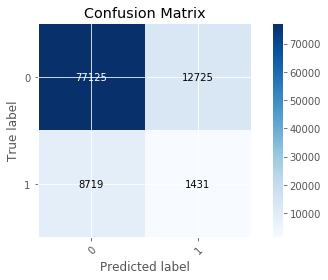

In [0]:
# Plot confusion matrix
plot_confusion_matrix(t_test, y_pred, classes=[0,1], normalize=False, title='Confusion Matrix')
plt.show()

In [0]:
#The accuracy rate
accuracy_score(t_test, y_pred)*100

87.428

In [0]:
# source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
target_names = ['class 0', 'class 1']
print(classification_report(t_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      0.91      0.93     90052
     class 1       0.41      0.58      0.48      9948

    accuracy                           0.87    100000
   macro avg       0.68      0.74      0.70    100000
weighted avg       0.90      0.87      0.88    100000



Due to the imbalance classes of the output, the Macro F1-score  seems to be more appropriate in measuring the accuracy of the model. The Macro F1 score of Logistic Bayesian Regression is at 70% compared with the 64% in Linear Bayesian Regression. 

### 4. e) Laplace approximation is an efficient way to obtain an approximate posterior for logistic regression. Describe the steps of this approach. What is the form of approximation obtained? (text) [5] 

The steps for Laplace approximation:
1. We approximate the true posterior $p(\mathbf{w}|\mathbf{X,t},\sigma^2)$ as $p(\mathbf{w}|\mathbf{X,t},\sigma^2) \approx \mathscr{N}(\mu,\Sigma)$
2. We got $\mu = \hat{w}$ and $\Sigma^{-1} = - \Big( \dfrac{\partial^2 log\mathsf{g}(\mathbf{w;X,t})}{\partial \mathbf{w}\partial\mathbf{w^T}} \Big)\Bigg|_{\hat{w}}$
3. Generate the sample weights from $\mu$ and $\Sigma$ 

Hessian matrix for the 2nd derivatives, with respect to $\mathbf{w^T}$:

$
\begin{align}
\dfrac{\partial^2 log\mathsf{g}(\mathbf{w;X,t})}{\partial \mathbf{w}\partial\mathbf{w^T}}
    &= -\dfrac{1}{\sigma^2}\mathbf{I} - \displaystyle\sum_{i=1}^{N} x_n \dfrac{\partial P_n}{\partial \mathbf{w}^T} \\
    &= -\dfrac{1}{\sigma^2}\mathbf{I} - \displaystyle\sum_{i=1}^{N} {x_n x_n^TP_n(1-P_n)} \\
    & \text{where } P_n = P(T_n = 1|\mathbf{w,x_n}) = \dfrac{1}{1 + exp(-\mathbf{w}^T\mathbf{x}_n)}\\
\end{align}
$

---

### 5. Implement the Laplace approximation and compare the predictive mean and variances with the ones obtained by linear regression. (code)

In [0]:
#implementation Hess
def Hess(X_, t, w, sigma2):
    Pn = 1/(1 + np.exp(-np.dot(X_,w)))
    Pn = Pn.flatten() 
    return -(1/sigma2)*np.eye(len(w)) - np.dot(X_.T,np.dot(np.diag(Pn*(1-Pn)),X_))

In [0]:
weight = np.genfromtxt("logisticweight.csv", delimiter=",") #read back the weights from previous question 4
sigma2 = 0.5 #initial sigma value

X_ = get_X(x_train, 1)

In [0]:
#Laplace approximation
g_mean = weight 
H = Hess(X_, t_train, g_mean, sigma2)
g_cov = np.linalg.inv(-H)
g_cov.shape

(201, 201)

In [0]:
# simulate 100 sample of weights 
weight_samps = np.random.multivariate_normal(g_mean.flatten(),g_cov,100)

In [0]:
#make predictive mean and variances of Laplace
# We only use 10,000 instances to predict the model due to the limitation of memory on Zoe
K=1
X_test = get_X(x_test[:10000],K)

mean_pred_laplace = (1/(1+np.exp(np.dot(X_test,-weight_samps.T)))).mean(axis=1) #Calculate the average mean 
var_pred_laplace = (1/(1+np.exp(np.dot(X_test,-weight_samps.T)))).var(axis=1) #Calculate the average covariance
mean_pred_laplace.shape, var_pred_laplace.shape

((10000,), (10000,))

Bayesian Linear predictve variances: $\sigma^2 + \mathbf{X^T_{new}}\Sigma\mathbf{X_{new}}$

In [0]:
#make predictive mean and variances of Bayesian Linear Regression
mean_pred_linear = np.dot(mean_posterior_linear, X_test.T) #Calculate the mean 

w_hat = get_w_hat(get_X(x_train, K), t_train, K)
sigma2_hat_linear = get_sigma2_hat(get_X(x_train, K), w_hat, t_train)
cov_pred_linear = sigma2_hat_linear + np.dot(X_test,cov_posterior_linear).dot(X_test.T) #Calculate the covariance 

mean_pred_linear.shape, cov_pred_linear.shape

((10000,), (10000, 10000))

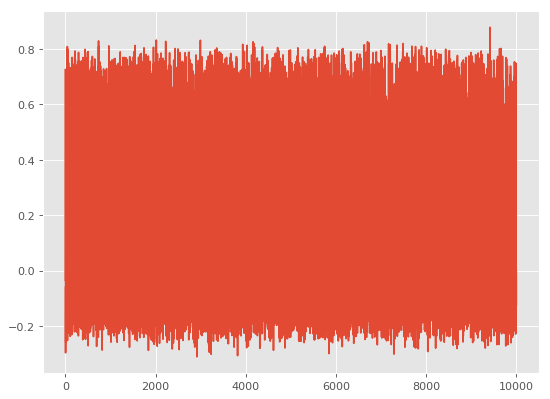

In [0]:
#Plot the differences between predictive mean of laplace and linear model
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(mean_pred_laplace - mean_pred_linear)

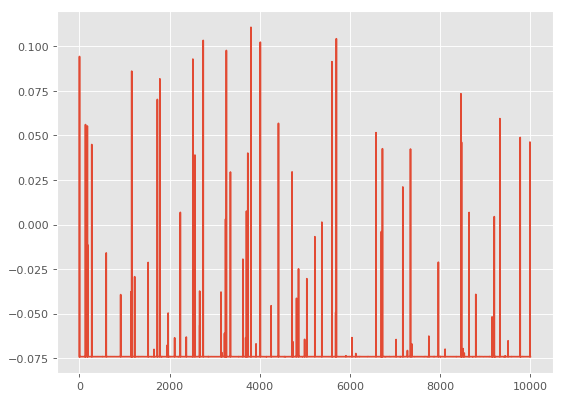

In [0]:
#Plot the differences between predictive covariance of laplace and linear model
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(var_pred_laplace - cov_pred_linear.diagonal())